In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

# turn off warnings
warnings.filterwarnings('ignore')

# Load the test data
y_test = pd.read_csv('data/processed/y_test_ml.csv')
X_train = pd.read_csv('data/processed/X_train_ml.csv')

# Load the model results dictionary
with open('models/model_results.pkl', 'rb') as f:
    model_results = pickle.load(f)

In [6]:
# Create a function to evaluate and display results
def evaluate_model(y_true, y_pred, y_proba=None):
    """Evaluate model performance with multiple metrics"""
    results = {}
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, zero_division=0)
    results['recall'] = recall_score(y_true, y_pred, zero_division=0)
    results['f1'] = f1_score(y_true, y_pred, zero_division=0)
    
    if y_proba is not None:
        results['auc'] = roc_auc_score(y_true, y_proba)
    
    return results

,accuracy,precision,recall,f1,auc
random_forest,0.994460,0.994152,0.994152,0.994152,0.999831
xgboost,0.988920,0.988304,0.988304,0.988304,0.998923
neural_network,0.991690,0.988372,0.994152,0.991254,0.999354
ft_transformer,0.991690,0.988372,0.994152,0.991254,0.999908
tab_transformer,0.986150,0.977011,0.994152,0.985507,0.999723


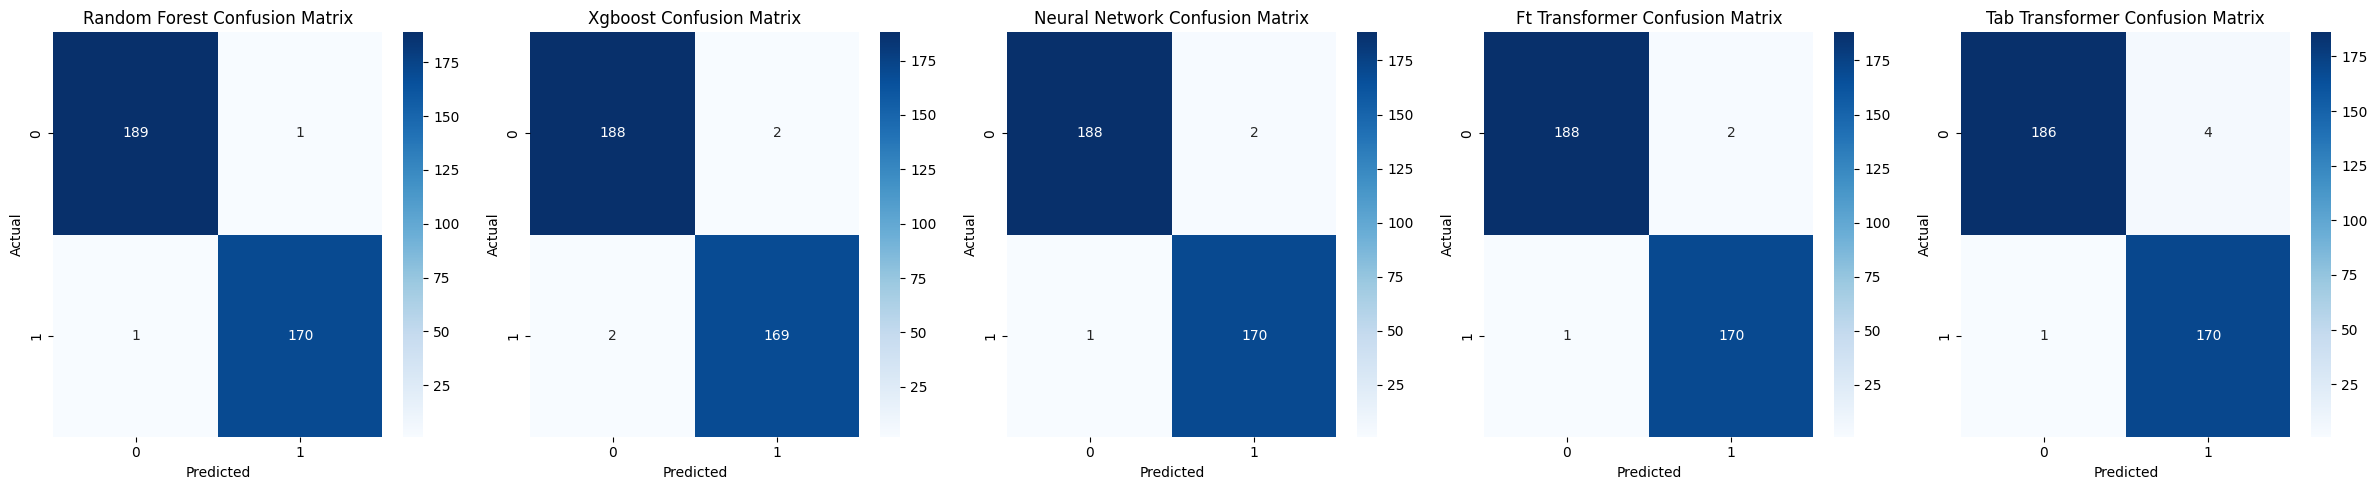

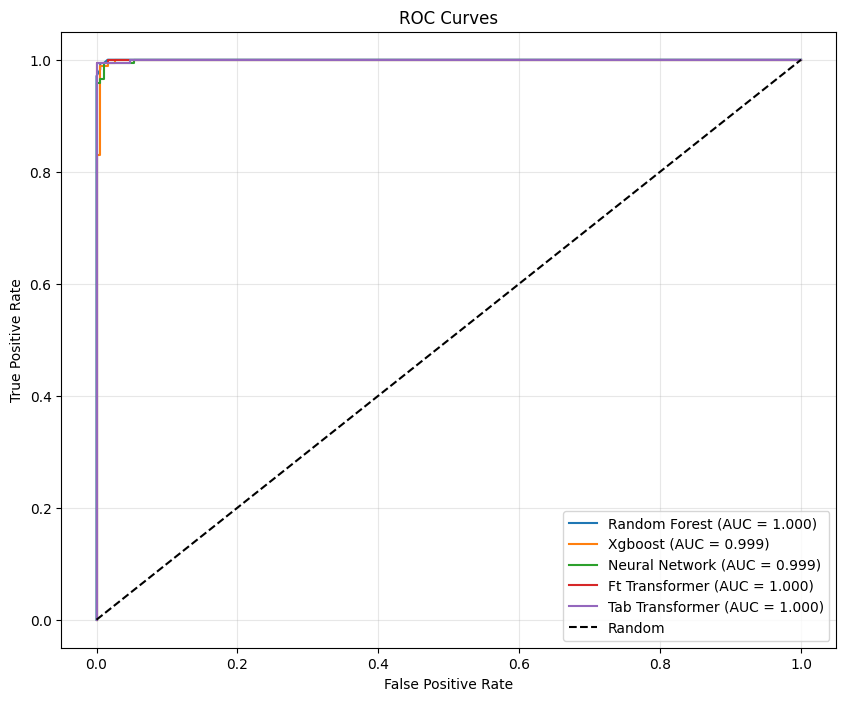

In [7]:


# Update the models list to include the FT Transformer
models = ['random_forest', 'xgboost', 'neural_network', 'ft_transformer', 'tab_transformer']

# Recalculate evaluation results for all models including FT Transformer
evaluation_results = {}

for model in models:
    test_preds = model_results[model]['test_preds']
    test_proba = model_results[model]['test_proba']
    evaluation_results[model] = evaluate_model(y_test, test_preds, test_proba)

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(evaluation_results).T
display(results_df.style.highlight_max(axis=0))

# Redraw confusion matrices with FT Transformer
fig, axes = plt.subplots(1, 5, figsize=(24, 5))

for i, model in enumerate(models):
    cm = confusion_matrix(y_test, model_results[model]['test_preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model.replace("_", " ").title()} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('images/ml_confusion_matrices.png', dpi=300)

# Redraw ROC curves including FT Transformer
plt.figure(figsize=(10, 8))

for model in models:
    y_proba = model_results[model]['test_proba']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model.replace("_", " ").title()} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('images/ml_roc_curves.png', dpi=300)

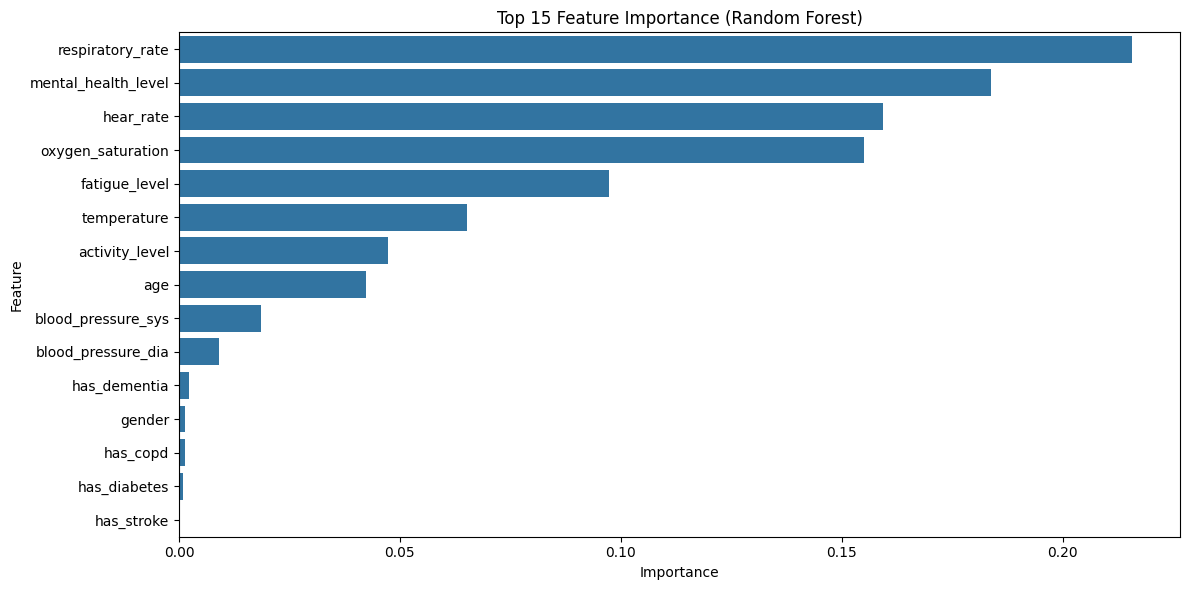

In [8]:
# Feature importance for Random Forest model (optional)
if 'random_forest' in model_results:
    # Load the Random Forest model
    with open('models/random_forest_model.pkl', 'rb') as f:
        rf_model = pickle.load(f)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

In [9]:
# Load the model results dictionary
with open('models/nlp_eval_results.pkl', 'rb') as f:
    eval_results = pickle.load(f)

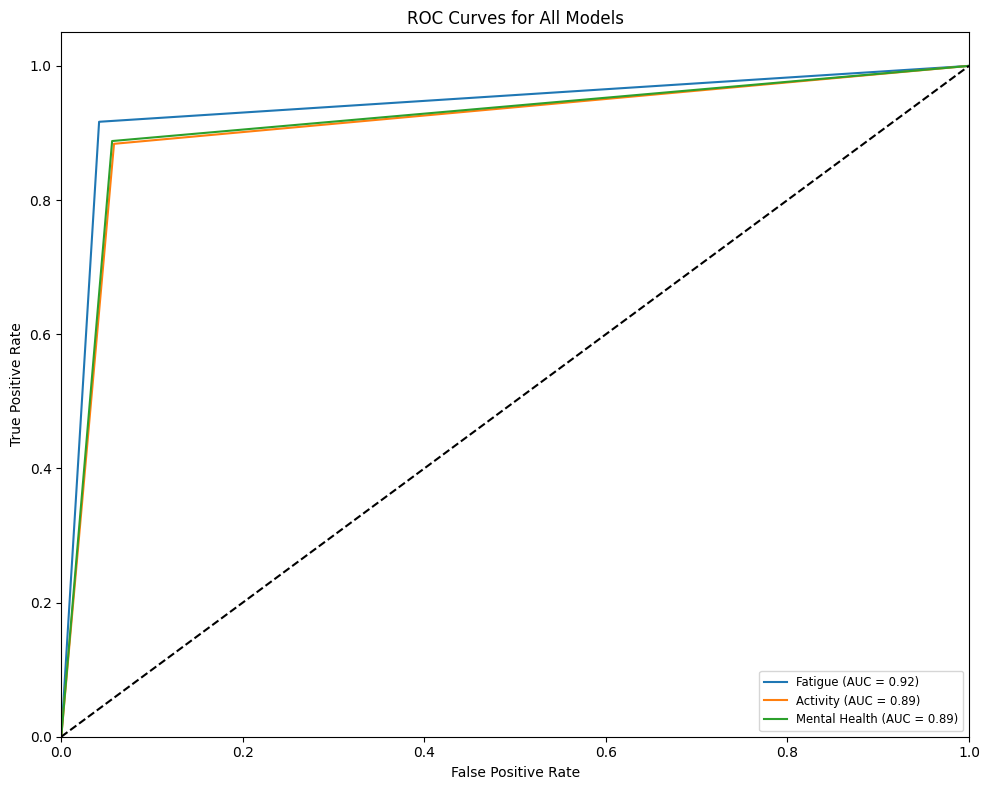

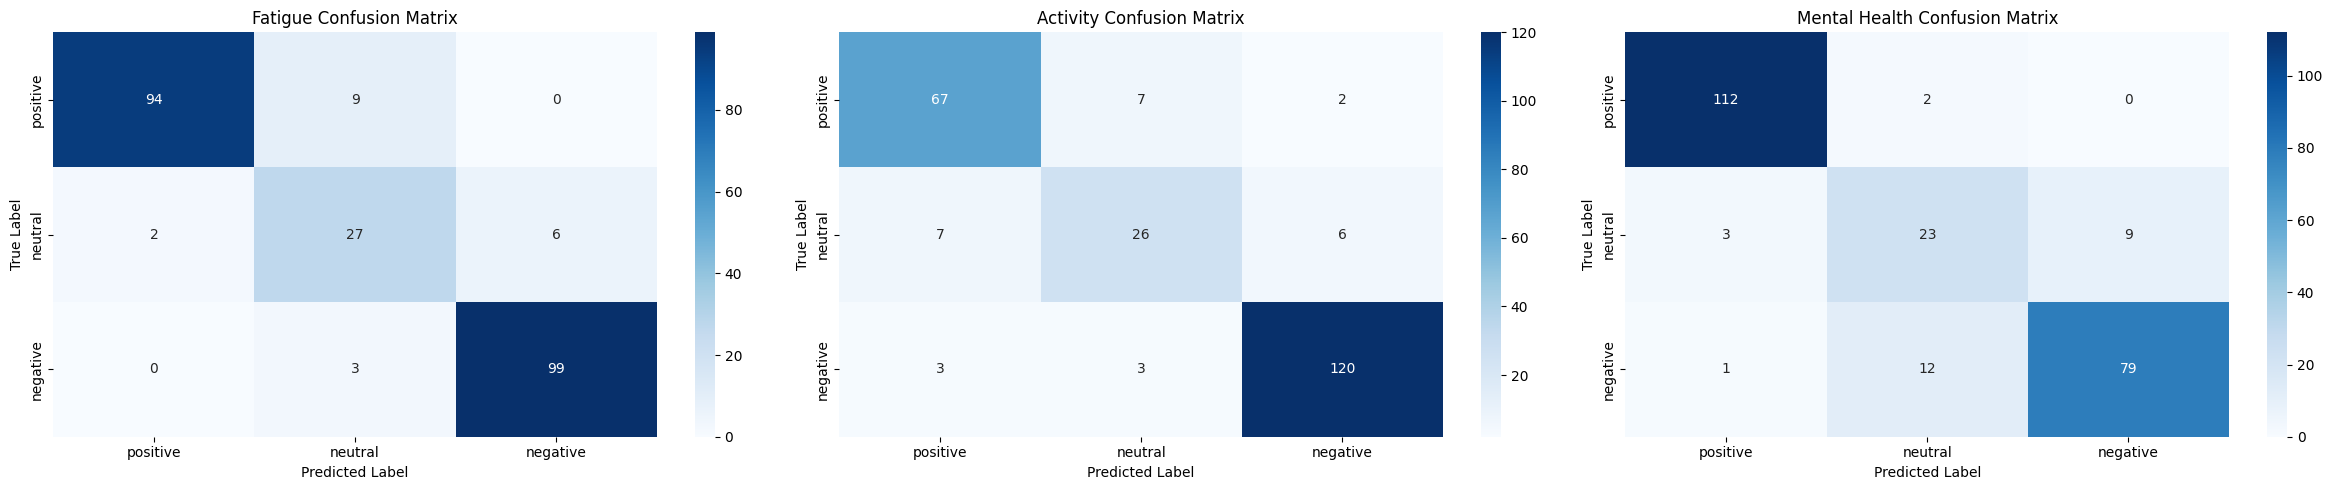

<Figure size 640x480 with 0 Axes>

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Fatigue,0.916667,0.921902,0.916667,0.918385,0.923004
1,Activity,0.883817,0.881417,0.883817,0.882395,0.886825
2,Mental Health,0.887967,0.889696,0.887967,0.888559,0.889739


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_and_visualize_models(eval_results):
    """Evaluate models and create visualizations."""
    # Create an empty list to store evaluation results as dictionaries
    eval_records = []
    
    # Classes for label mapping
    classes = ['positive', 'neutral', 'negative']
    
    # Set up the figure for confusion matrices
    fig_cm, axes_cm = plt.subplots(1, 3, figsize=(24, 5))
    
    # Create a separate figure for the ROC curve
    fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
    
    # Process each model's results
    for i, (model_name, (true_labels, predictions)) in enumerate(eval_results.items()):
        # Get the classification report as a dict
        report = classification_report(true_labels, predictions, 
                                       target_names=classes, 
                                       output_dict=True)
        
        # Calculate average AUC across all classes for this model
        model_auc = 0
        for class_idx, class_name in enumerate(classes):
            y_true_class = (np.array(true_labels) == class_idx).astype(int)
            y_pred_class = (np.array(predictions) == class_idx).astype(int)
            fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
            model_auc += auc(fpr, tpr)
        model_auc /= len(classes)  # Average AUC across all classes
        
        # Add a single record for this model (moved outside the class loop)
        eval_records.append({
            'Model': model_name,
            'Accuracy': report['accuracy'],
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
            'AUC': model_auc
        })
        
        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes, ax=axes_cm[i])
        axes_cm[i].set_title(f'{model_name} Confusion Matrix')
        axes_cm[i].set_ylabel('True Label')
        axes_cm[i].set_xlabel('Predicted Label')
        
        # One-hot encode true labels for micro-averaging
        n_classes = 3
        y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
        
        # For each model, generate prediction scores for each class
        # We'll use the predicted classes directly for simplicity
        y_score = label_binarize(predictions, classes=[0, 1, 2])
        
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve for this model (one line per model)
        ax_roc.plot(fpr, tpr, 
                    label=f'{model_name} (AUC = {model_auc:.2f})')
    
    
    # Add diagonal line to ROC plot
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC Curves for All Models')
    ax_roc.legend(loc="lower right", fontsize='small')
    
    # Adjust layout and save figures
    fig_cm.tight_layout()
    fig_cm.savefig('images/sa_confusion_matrices.png', dpi=300, bbox_inches='tight')
    
    fig_roc.tight_layout()
    fig_roc.savefig('images/sa_roc_curves.png', dpi=300, bbox_inches='tight')
    
    # Show both figures
    plt.figure(fig_cm.number)
    plt.show()
    plt.figure(fig_roc.number)
    plt.show()
    
    # Create DataFrame from the list of records
    eval_df = pd.DataFrame(eval_records)
    
    # Save evaluation results to CSV
    eval_df.to_csv('data/output/sentiment_model_evaluation.csv', index=False)
    
    # Display the evaluation table
    display(eval_df.style.highlight_max(axis=0))
    
    return eval_df

eval_df = evaluate_and_visualize_models(eval_results)

Model Performance Metrics:


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.998087,0.908416,0.943445,0.925599,0.999606


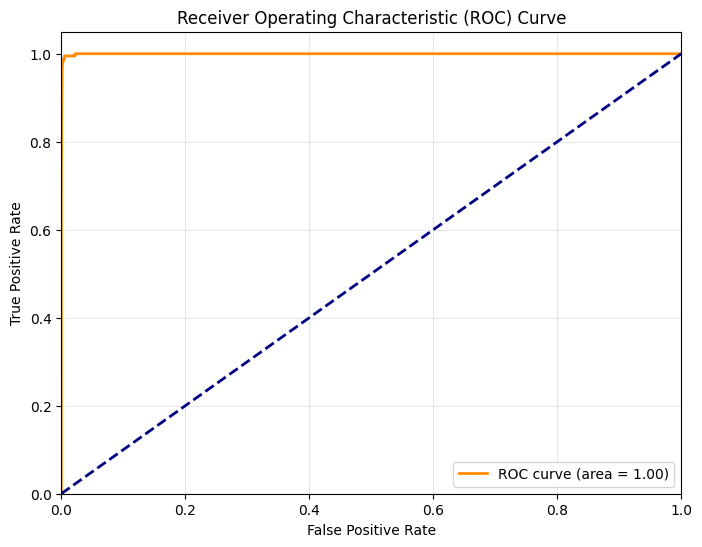

In [2]:
# Load the model results 
with open('models/bert_ner_eval/binary_labels.pkl', 'rb') as f:
    binary_labels = pickle.load(f)

with open('models/bert_ner_eval/ner_metrics.pkl', 'rb') as f:
    metrics_df = pickle.load(f)

with open('models/bert_ner_eval/prob_preds_flat.pkl', 'rb') as f:
    prob_preds_flat = pickle.load(f)

# Display metrics table
print("Model Performance Metrics:")
display(metrics_df)

# Plot ROC curve
fpr, tpr, _ = roc_curve(binary_labels, prob_preds_flat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('images/ner_roc_curve.png')
plt.show()

In [2]:
# Load the model results dictionary
with open('models/qr_eval_results.pkl', 'rb') as f:
    eval_results = pickle.load(f)

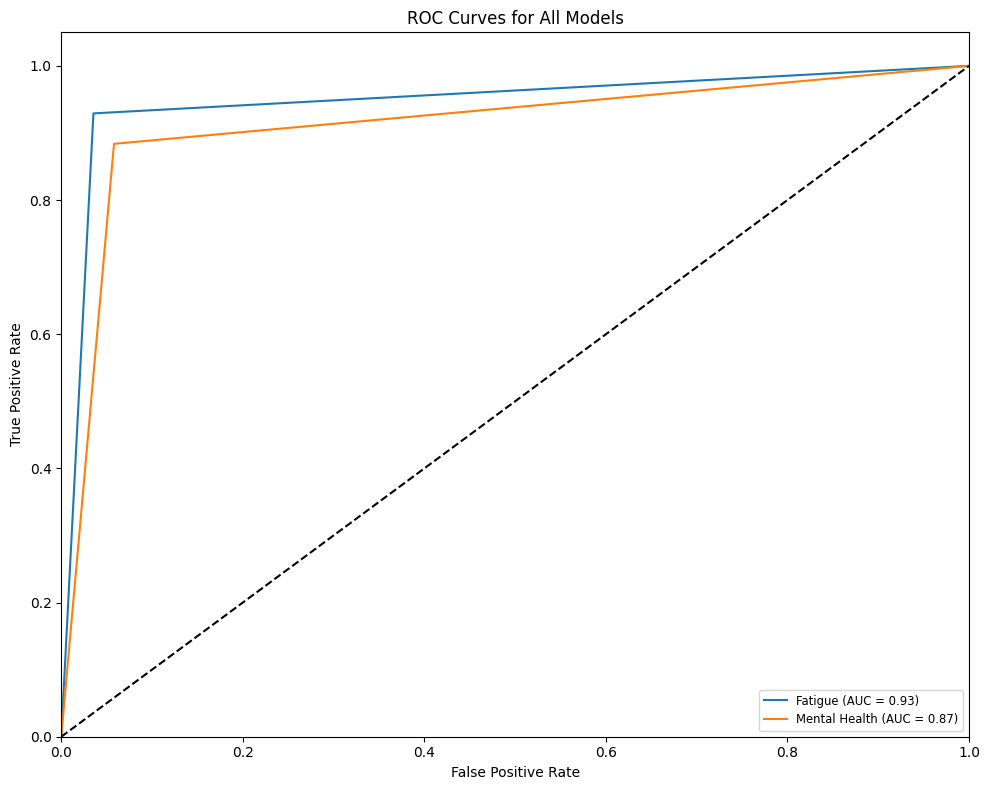

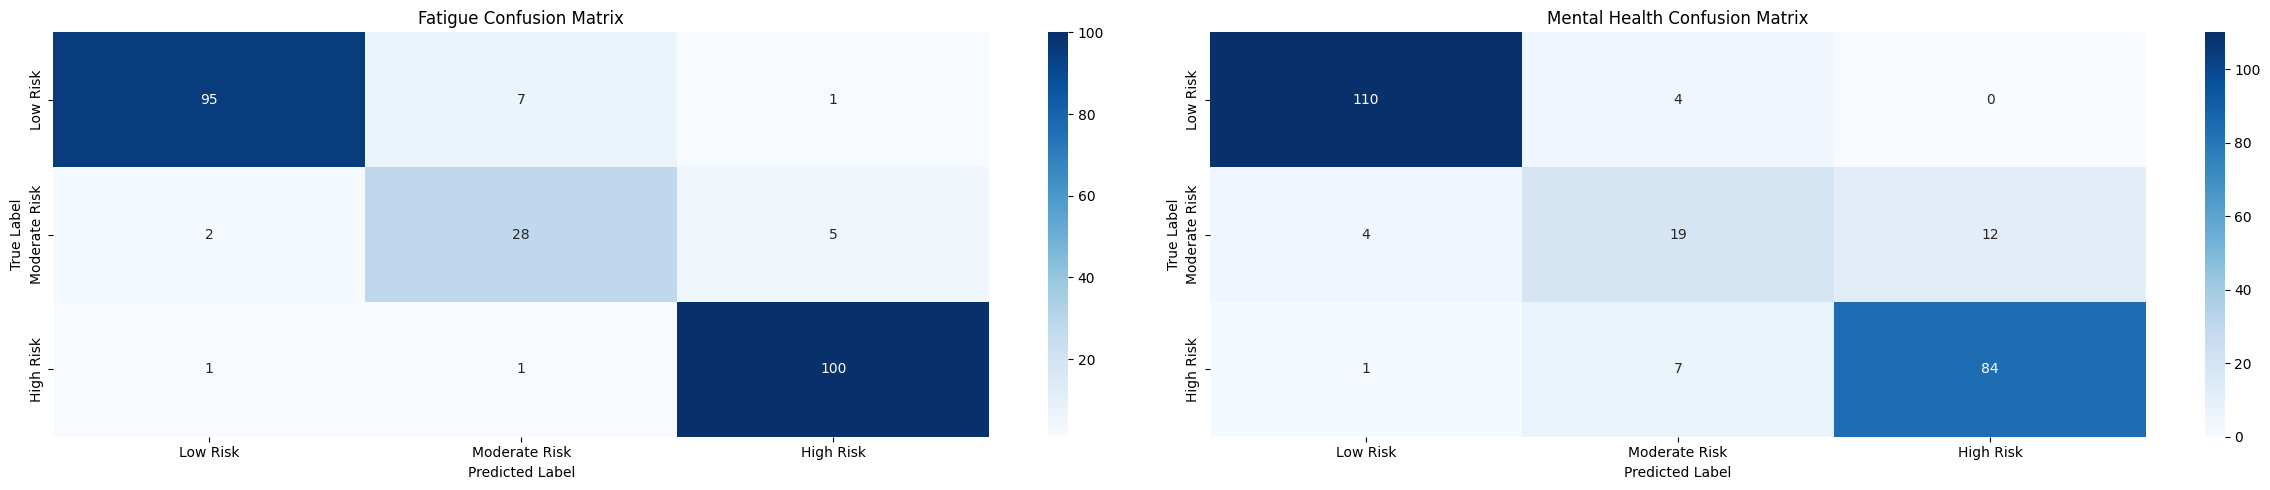

<Figure size 640x480 with 0 Axes>

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Fatigue,0.929167,0.930398,0.929167,0.929357,0.933054
1,Mental Health,0.883817,0.878465,0.883817,0.880473,0.874585


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_and_visualize_models(eval_results):
    """Evaluate models and create visualizations."""
    # Create an empty list to store evaluation results as dictionaries
    eval_records = []
    
    # Classes for label mapping
    classes = ['Low Risk', 'Moderate Risk', 'High Risk']
    
    # Set up the figure for confusion matrices
    fig_cm, axes_cm = plt.subplots(1, 2, figsize=(24, 5))
    
    # Create a separate figure for the ROC curve
    fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
    
    # Process each model's results
    for i, (model_name, (true_labels, predictions)) in enumerate(eval_results.items()):
        # Get the classification report as a dict
        report = classification_report(true_labels, predictions, 
                                       target_names=classes, 
                                       output_dict=True)
        
        # Calculate average AUC across all classes for this model
        model_auc = 0
        for class_idx, class_name in enumerate(classes):
            y_true_class = (np.array(true_labels) == class_idx).astype(int)
            y_pred_class = (np.array(predictions) == class_idx).astype(int)
            fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
            model_auc += auc(fpr, tpr)
        model_auc /= len(classes)  # Average AUC across all classes
        
        # Add a single record for this model (moved outside the class loop)
        eval_records.append({
            'Model': model_name,
            'Accuracy': report['accuracy'],
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
            'AUC': model_auc
        })
        
        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes, ax=axes_cm[i])
        axes_cm[i].set_title(f'{model_name} Confusion Matrix')
        axes_cm[i].set_ylabel('True Label')
        axes_cm[i].set_xlabel('Predicted Label')
        
        # One-hot encode true labels for micro-averaging
        n_classes = 3
        y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
        
        # For each model, generate prediction scores for each class
        # We'll use the predicted classes directly for simplicity
        y_score = label_binarize(predictions, classes=[0, 1, 2])
        
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve for this model (one line per model)
        ax_roc.plot(fpr, tpr, 
                    label=f'{model_name} (AUC = {model_auc:.2f})')
    
    
    # Add diagonal line to ROC plot
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC Curves for All Models')
    ax_roc.legend(loc="lower right", fontsize='small')
    
    # Adjust layout and save figures
    fig_cm.tight_layout()
    fig_cm.savefig('images/qr_confusion_matrices.png', dpi=300, bbox_inches='tight')
    
    fig_roc.tight_layout()
    fig_roc.savefig('images/qr_roc_curves.png', dpi=300, bbox_inches='tight')
    
    # Show both figures
    plt.figure(fig_cm.number)
    plt.show()
    plt.figure(fig_roc.number)
    plt.show()
    
    # Create DataFrame from the list of records
    eval_df = pd.DataFrame(eval_records)
    
    # Save evaluation results to CSV
    eval_df.to_csv('data/output/classification_qr_model_evaluation.csv', index=False)
    
    # Display the evaluation table
    display(eval_df.style.highlight_max(axis=0))
    
    return eval_df

eval_df = evaluate_and_visualize_models(eval_results)